$$ ITI \space AI-Pro: \space Intake \space 44 $$
$$ Machine \space Learning \space 1 $$
$$ Lab \space no. \space 2 $$

# `01` Import Necessary Libraries

## `i` Default Libraries

In [73]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

## `ii` Additional Libraries
Add imports for additional libraries you used throughout the notebook

In [74]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

## Bonus Section
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

----------------------------

# `02` Load Data

In [75]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [76]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


## `#` Create Test Set

Before exploring the data, let's split the data into training and test sets. You shouldn't touch the test set from this point furthur except for final model evaluation.

Use:
- `random_state` $= 1234$
- `test_size` $= 0.2$

Hint: You can use `sklearn.model_selection.train_test_split` function

In [77]:
X_train, X_test, y_train, y_test = train_test_split(housing.drop(columns=['median_house_value']), housing['median_house_value'], random_state=1234, test_size=0.2)

In [78]:
print(f'Training Set Size: {X_train.shape[0]} instances.')
print(f'Testing Set Size: {X_test.shape[0]} instances.')

Training Set Size: 16512 instances.
Testing Set Size: 4128 instances.


----------------

# `03` Exploratory Data Analysis (EDA)

## `i` Simple Analysis

Preview data, perform statistical data analysis and explore as much as needed to better understand the data set we're dealing with.

`Note:` Feel free to look up EDA approaches online for inspiration (however you **must understand** everything and not copy paste).

In [79]:
# Preview Data
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17595,-120.07,36.98,12.0,1790.0,379.0,1399.0,397.0,2.5388,INLAND
6073,-118.22,33.86,16.0,8732.0,1489.0,3944.0,1493.0,5.1948,<1H OCEAN
6251,-120.94,39.32,14.0,3120.0,595.0,1569.0,556.0,3.5385,INLAND
3161,-122.11,37.68,37.0,1976.0,481.0,1197.0,465.0,2.5772,NEAR BAY
1887,-121.34,38.67,35.0,643.0,117.0,331.0,134.0,3.0417,INLAND


In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17595 to 1318
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


Notes:
- There seems to be 8 numerical features and only 1 categorical feature.
- Some values are missing in the `total_bedrooms` features (will need to handle these records using imputation, dropping, etc.)

In [81]:
# Simple Statistical Analysis
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.576297,35.640944,28.629300,2634.395652,537.400086,1422.226562,499.014595,3.869583
std,2.008301,2.141025,12.622547,2195.367194,422.272540,1119.964665,383.148507,1.896395
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.802500,33.930000,18.000000,1452.750000,296.000000,786.000000,280.000000,2.562500
50%,-118.500000,34.260000,29.000000,2128.000000,435.000000,1166.000000,410.000000,3.539400
75%,-118.010000,37.720000,37.000000,3138.250000,646.000000,1720.000000,603.000000,4.748350
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100


Notes:
- Some of the numerical features have a very high scales in comparison with the rest. (We might need to use a scaler to resolve this)
- Some features seem to be skewed (will be confirmed through the visual analysis later)

In [82]:
# Check for Nulls Percentage
X_train.isna().sum().sort_values(ascending=False)/X_train.shape[0]*100

total_bedrooms        0.95688
longitude             0.00000
latitude              0.00000
housing_median_age    0.00000
total_rooms           0.00000
population            0.00000
households            0.00000
median_income         0.00000
ocean_proximity       0.00000
dtype: float64

Notes:
- As mentioned before, only the `total_bedrooms` feature contain a few missing values (less than $1\%$ of the records)

In [83]:
# Check for Duplicates
X_train.duplicated().sum()

0

Notes:
- There are no duplicate records.

## `ii` Visual Analysis

Plot graphs and relations in order to gain more insights about the data set, identify patterns, and make assumptions.

`Note:` Feel free to look up visual EDA approaches online for inspiration (however you **must understand** everything and not copy paste).

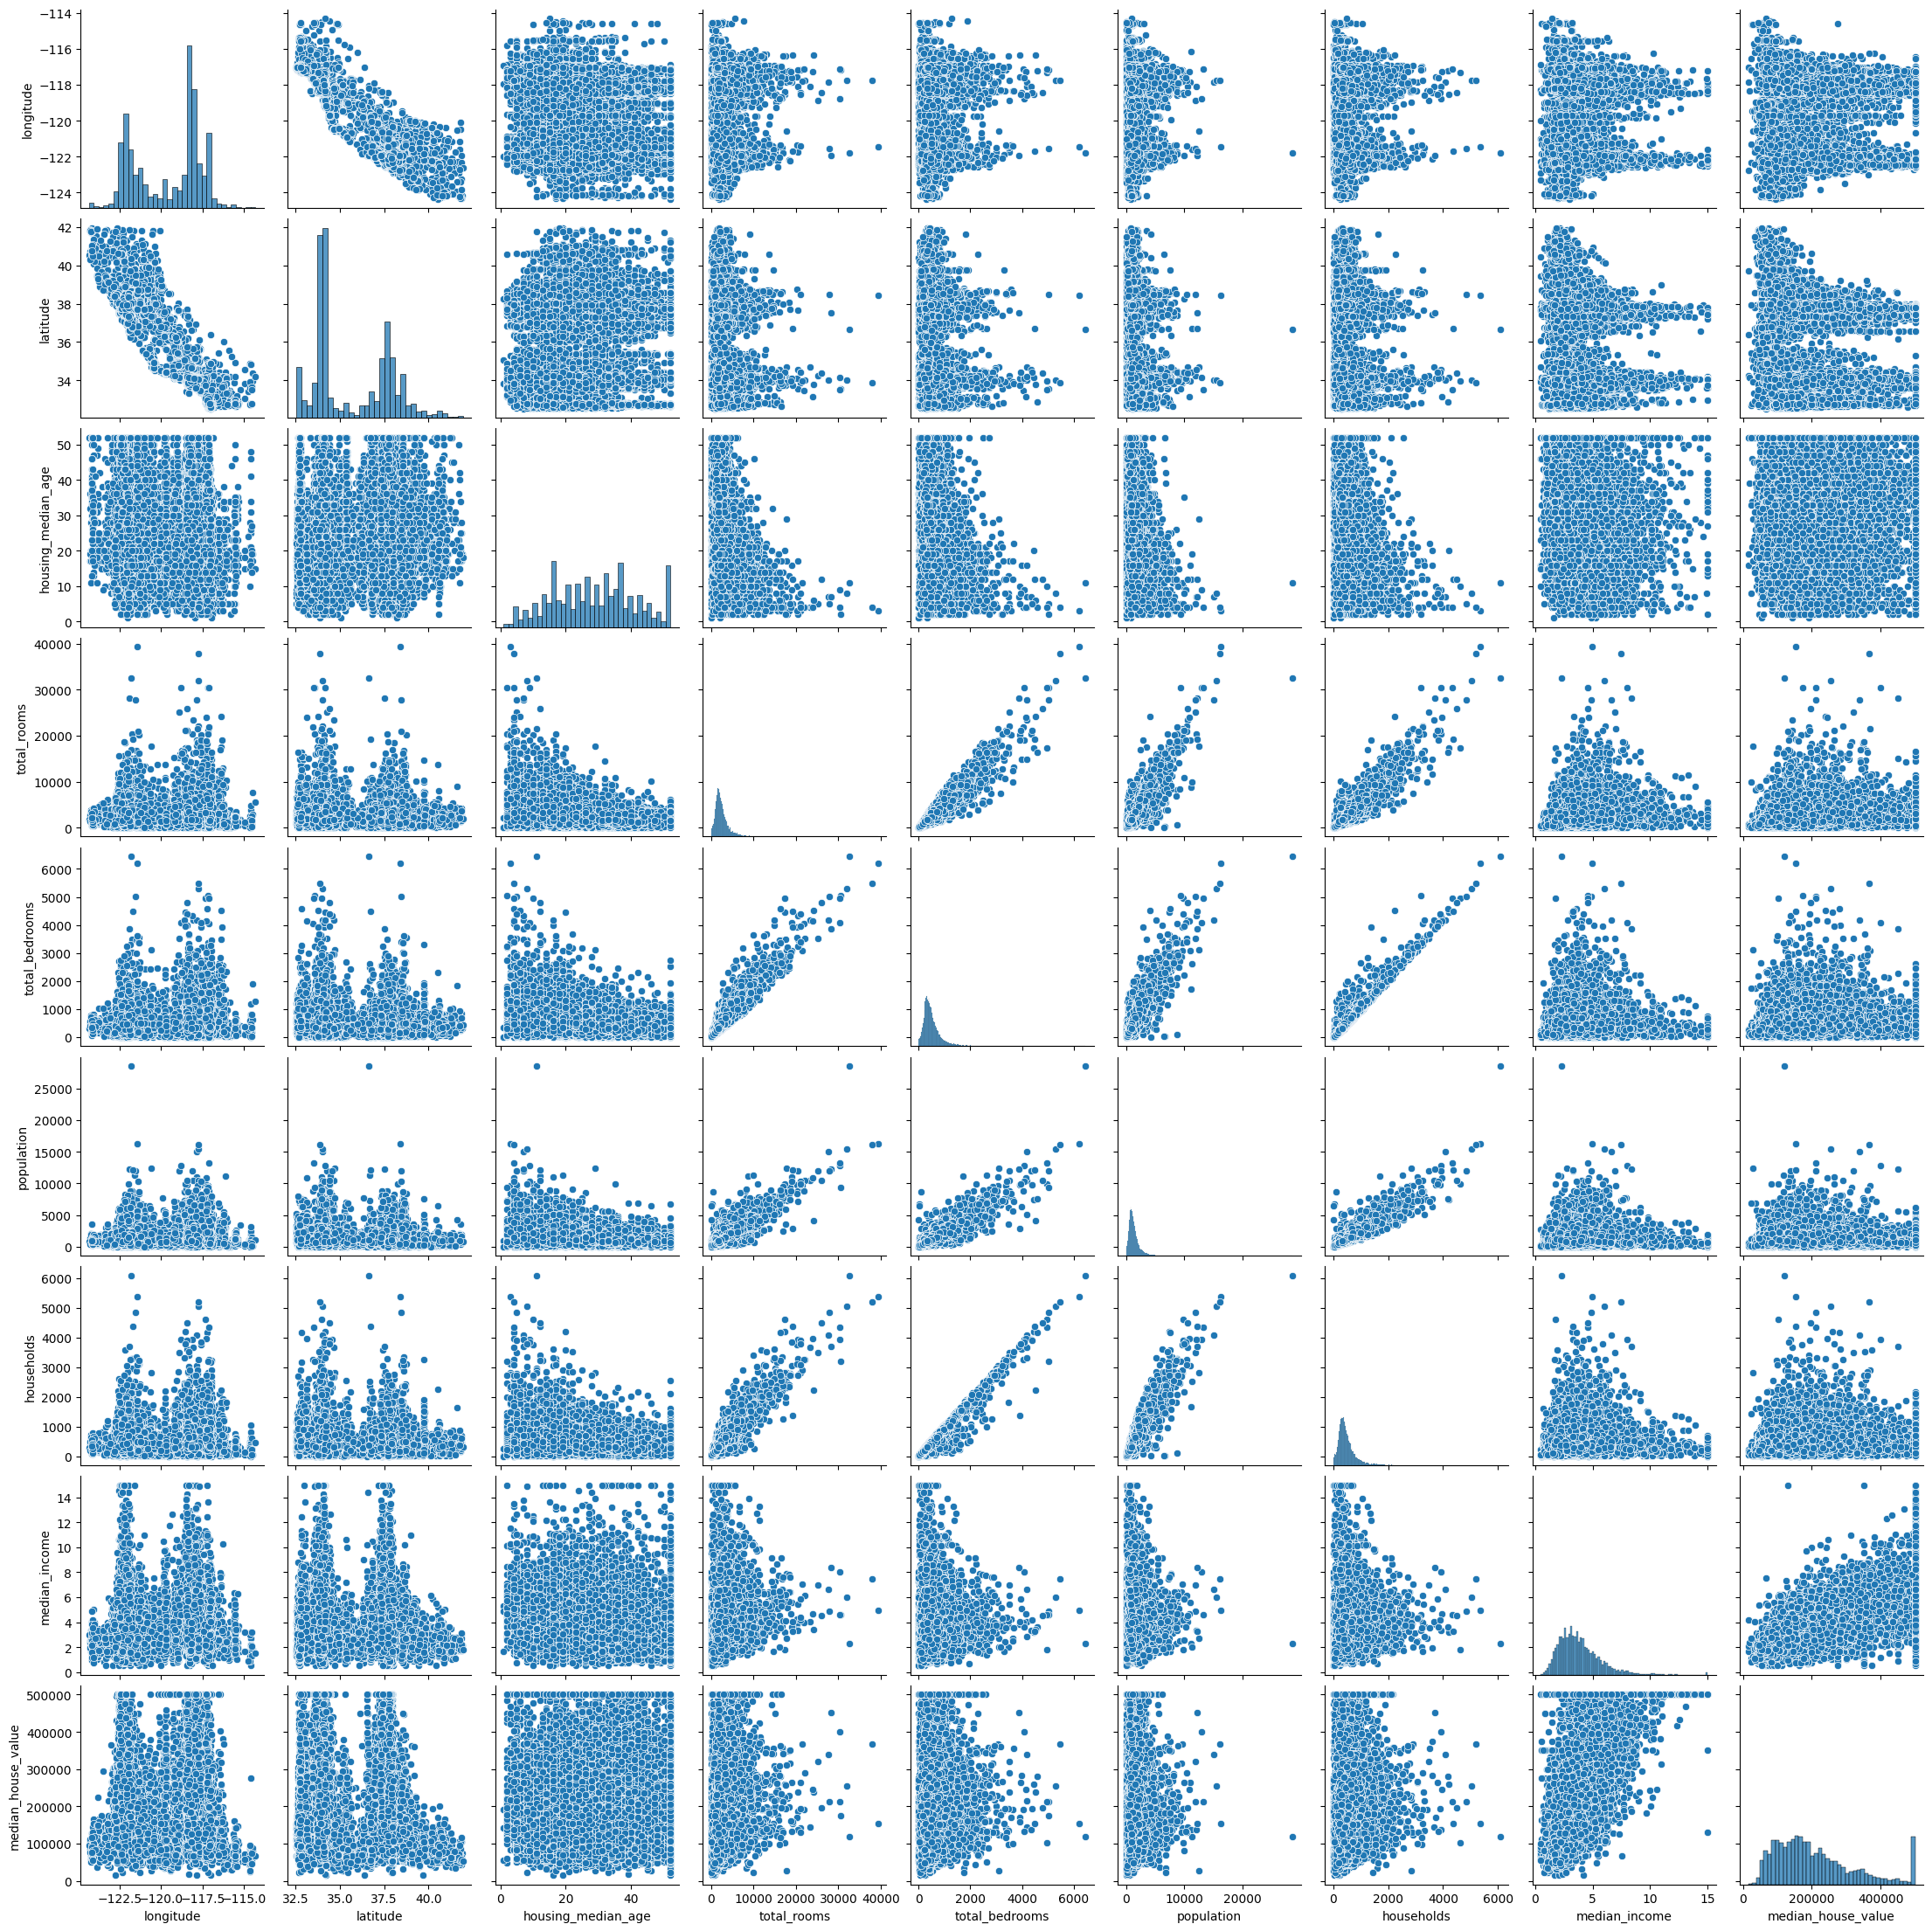

In [84]:
# Pair Plot
train = X_train.copy()
train['median_house_value'] = y_train
sns.pairplot(train)

Notes:
- Some features (such as: `total_rooms`, `households`, `population`, `median_income`, etc.) are skewed (Might need handling)
- Target column `median_house_value` has a strange pattern (there seem to be a high density area around a certain value. Needs further investigation).
- There doesn't seem to be a strong "visible" correlation between the target and any other feature.

----------------

# `04` Data Preparation

Perform data cleaning, feature engineering, scaling, etc. as needed to make sure it's ready for the model.

Hint: It could be helpful to check `sklearn.preprocessing` module.

In [85]:
# Null Values Handling

imputer = SimpleImputer(strategy='median')
X_train[X_train.select_dtypes('number').columns] = imputer.fit_transform(X_train[X_train.select_dtypes('number').columns])

In [14]:
X_train.isna().sum().sort_values(ascending=False)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

Notes:
- Null values handling is done.

In [15]:
# Feature Engineering

def extract_room_related_features(df: pd.DataFrame) -> pd.DataFrame:
  """
  Create 3 new columns related to the rooms and household features.

  Parameters
  ----------
  df : pandas.DataFrame
       The dataframe containing the housing dataset features

  Returns
  -------
  pandas.DataFrame
       The transformed dataframe including the 3 new features
  """

  cols = ['total_rooms', 'total_bedrooms', 'households', 'population']
  assert all(col in df.columns for col in cols), f"The df dataframe must have {cols} columns"

  df_tr = df.copy()

  df_tr['bedrooms_per_room'] = df_tr['total_bedrooms'] / df_tr['total_rooms']
  df_tr['rooms_per_household'] = df_tr['total_rooms'] / df_tr['households']
  df_tr['population_per_household'] = df_tr['population'] / df_tr['households']

  return df_tr

In [16]:
X_train = extract_room_related_features(X_train)
print(f'Training Features: {list(X_train.columns)}')

Training Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity', 'bedrooms_per_room', 'rooms_per_household', 'population_per_household']


Notes:
- Adding these features might give the model an extra intrinsic patterns in the data (e.g., detecting the high density areas and how that relates to the house value)
- Used a function to make it easier to reuse the transformation on the test data later.

In [17]:
# Categorical Data Encoding

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train[ohe.get_feature_names_out()] = ohe.fit_transform(X_train[X_train.select_dtypes('object').columns])
X_train.drop(columns=['ocean_proximity'], inplace=True)

Notes:
- Using One Hot Encoding to encode the categorical feature `ocean_proximity`.

In [18]:
# Scaling

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

Notes:
- Using `RobustScaler` to scale the features.
- Robust scaling utilizes quantiles and is less sensitive to outliers.

## `#` Prepare Test Set

Apply the data transformations you used on the training set to the test set.

**Important Note:** DO NOT use `fit` on the test set.

In [19]:
# Null Handling

X_test[X_test.select_dtypes('number').columns] = imputer.transform(X_test[X_test.select_dtypes('number').columns])

Notes:
- Used the same `SimpleImputer` object instance used on the training set to transform the test set.
- We must do that and **NEVER** use `fit` on the test set.

In [20]:
# Feature Extraction

X_test = extract_room_related_features(X_test)
print(f'Testing Features: {list(X_test.columns)}')

Testing Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity', 'bedrooms_per_room', 'rooms_per_household', 'population_per_household']


Notes:
- Extracting the 3 new features in the same order.
- Using a function makes the process easier and more streamlined.

In [21]:
# Categorical Data Encoding

X_test[ohe.get_feature_names_out()] = ohe.transform(X_test[X_test.select_dtypes('object').columns])
X_test.drop(columns=['ocean_proximity'], inplace=True)

Notes:
- Using the same `OneHotEncoder` class instance fitted on the training set.
- **NEVER** use `fit` on the test set.

In [22]:
# Scaling

X_test = scaler.transform(X_test)

Notes:
- Scale the test set via `transform` method using the **same** `RobustScaler` class instance fitted on the training set.

----------------------------

# `05` Normal Equation

Using `sklearn` implementation of the linear regression closed-form solution, i.e. normal equation, to model the data.

Hint: Look for `sklearn.linear_model.LinearRegression` class.

## `i` Model Training

Initializing the model, fitting it to the training data, and get a fitted model.

In [23]:
# Instantiate the model instance

ne_model = LinearRegression()

In [24]:
# Fit the model on the training data

ne_model.fit(X_train, y_train)

LinearRegression()

## `ii` Model Evaluation

Evaluate model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [87]:
def regression_report(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> None:
  """Compute and print out MSE, RMSE, MAE, and R-squared score for the provided `model` on the provided `X` and `y`."""
  print('Training Set Evaluation:')

  # Mean Squared Error
  print(f'- Mean Squared Error: {mean_squared_error(y, model.predict(X))}')
  print(f'- Root Mean Squared Error: {mean_squared_error(y, model.predict(X), squared=False)}')

  # Mean Absolute Error
  print(f'- Mean Absolute Error: {mean_absolute_error(y, model.predict(X))}')

  # R-Squared Score
  print(f'- R-Squared Score: {r2_score(y, model.predict(X))*100:.4f}%')

Notes:
- Any baseline and/or intermediary model evaluation is **STRICTLY** done using training/validation set.
- Testing set is only used to evaluate the final model as an approximate estimation of the generalization error.

In [26]:
regression_report(ne_model, X_train, y_train)

Training Set Evaluation:
- Mean Squared Error: 4637934954.908942
- Root Mean Squared Error: 68102.3858239118
- Mean Absolute Error: 49385.65908227543
- R-Squared Score: 65.3060%


Notes:
- The baseline model (normal equation) training error ranges between $49$-$68K$ which is relatively high.
- The r-squared score is at $65\%$.
- We can try more complex model.


----------------------

# `06` Linear Regression with Gradient Descent

Using `sklearn` implementation of linear regression to model the data.

Hint: Look for `sklearn.linear_model.SGDRegressor` class.

## `i` Baseline Model Training

Initializing the model with initial parameters, fitting it to the training data, and get a baseline model.

Use:
- Non-regularized model.
- Constant `learning_rate`

In [30]:
# Instantiate the model

sgd_model = SGDRegressor(penalty=None, learning_rate='constant')

In [31]:
# Fit the model on training data

sgd_model.fit(X_train, y_train)

SGDRegressor(learning_rate='constant', penalty=None)

## `ii` Model Evaluation

Evaluate the baseline model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [34]:
regression_report(sgd_model, X_train, y_train)

Training Set Evaluation:
- Mean Squared Error: 2.910971688868482e+21
- Root Mean Squared Error: 53953421475.08795
- Mean Absolute Error: 24172241488.4189
- R-Squared Score: -21775498271701.2578%


Notes:
- The model performance is clearly worse.
- We can do some debugging to investigate this.

In [39]:
print(f'Model training iterations: {sgd_model.n_iter_}')

Model training iterations: 6


Notes:
- It seems the model's early stopping cuts the training process short from the beginning.
- Let's try to prevent that.

In [50]:
# Increasing both `max_iter` and `n_iter_no_change` and observing

sgd_model_2 = SGDRegressor(penalty=None, learning_rate='constant', n_iter_no_change=3000, early_stopping=True, max_iter=10_000, random_state=1234).fit(X_train, y_train)
print(f'Model training iterations: {sgd_model_2.n_iter_}')

regression_report(sgd_model_2, X_train, y_train)

Model training iterations: 3125
Training Set Evaluation:
- Mean Squared Error: 1.2150451321791005e+24
- Root Mean Squared Error: 1102290856434.4985
- Mean Absolute Error: 86925466522.51778
- R-Squared Score: -9089134489731420.0000%


## `iii` Tune `learning_rate`

Try different `learning_rate` values and evaluate. What is the optimal learning rate?

Hint: You might want to use `sklearn.model_selection.RandomizedSearchCV` or `sklearn.model_selection.GridSearchCV` classes.

In [52]:
sgd_model_3 = SGDRegressor(penalty=None, learning_rate='constant', n_iter_no_change=3000, early_stopping=True, max_iter=10_000, random_state=1234)
params = {'eta0': np.linspace(0.0001, 1, 100)}
clf = RandomizedSearchCV(sgd_model_3, params, n_jobs=-1, scoring='neg_mean_squared_error', random_state=1234, verbose=15)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=SGDRegressor(early_stopping=True,
                                          learning_rate='constant',
                                          max_iter=10000, n_iter_no_change=3000,
                                          penalty=None, random_state=1234),
                   n_jobs=-1,
                   param_distributions={'eta0': array([1.000e-04, 1.020e-02, 2.030e-02, 3.040e-02, 4.050e-02, 5.060e-02,
       6.070e-02, 7.080e-02, 8.090e-02, 9.100e-02, 1.011e-01, 1.112e-01,
       1.213e-01, 1.314e-01, 1.415e-01...
       6.667e-01, 6.768e-01, 6.869e-01, 6.970e-01, 7.071e-01, 7.172e-01,
       7.273e-01, 7.374e-01, 7.475e-01, 7.576e-01, 7.677e-01, 7.778e-01,
       7.879e-01, 7.980e-01, 8.081e-01, 8.182e-01, 8.283e-01, 8.384e-01,
       8.485e-01, 8.586e-01, 8.687e-01, 8.788e-01, 8.889e-01, 8.990e-01,
       9.091e-01, 9.192e-01, 9.293e-01, 9.394e-01, 9.495e-01, 9.596e-01,
       9.697e-01, 9.798e-01, 9.899e-01, 1.000e+00])},
                   random_state=1234, scoring='neg_mean_squared_error',
                   verbose=15)

In [56]:
clf.best_params_

{'eta0': 0.40409999999999996}

In [57]:
print(f'Model training iterations: {clf.best_estimator_.n_iter_}')

Model training iterations: 3571


In [55]:
regression_report(clf.best_estimator_, X_train, y_train)

Training Set Evaluation:
- Mean Squared Error: 1.3379998185821662e+25
- Root Mean Squared Error: 3657867983651.3594
- Mean Absolute Error: 2177990834550.3276
- R-Squared Score: -100088959465392720.0000%


## `iv` Regularization Mode: On

Let's try $l_1$ and $l_2$ regularization. Use default parameters for simplicity. Does regularization made the model generalize better?

Which of the two regularizations performs better?

In [53]:
# L1 Regularization

sgd_model_l1 = SGDRegressor(penalty='l1', learning_rate='constant', n_iter_no_change=3000, early_stopping=True, max_iter=10_000, random_state=1234)
sgd_model_l1.fit(X_train, y_train)
print(f'Model training iterations: {sgd_model_l1.n_iter_}')

regression_report(sgd_model_l1, X_train, y_train)

Model training iterations: 3125
Training Set Evaluation:
- Mean Squared Error: 1.2150451159205512e+24
- Root Mean Squared Error: 1102290849059.608
- Mean Absolute Error: 86925466551.0881
- R-Squared Score: -9089134368109484.0000%


In [54]:
# L2 Regularization

sgd_model_l2 = SGDRegressor(penalty='l2', learning_rate='constant', n_iter_no_change=3000, early_stopping=True, max_iter=10_000, random_state=1234)
sgd_model_l2.fit(X_train, y_train)
print(f'Model training iterations: {sgd_model_l2.n_iter_}')

regression_report(sgd_model_l2, X_train, y_train)

Model training iterations: 3001
Training Set Evaluation:
- Mean Squared Error: 2.286792492616407e+24
- Root Mean Squared Error: 1512214433410.9521
- Mean Absolute Error: 111017496143.915
- R-Squared Score: -17106331250611540.0000%


------------------

# `07` Generalization Error

Now that we have tuned our solution, to an *extent*, we need to test for a final time on the held out test set.

In [58]:
regression_report(ne_model, X_test, y_test)

Training Set Evaluation:
- Mean Squared Error: 4820231640.5447645
- Root Mean Squared Error: 69427.88806052481
- Mean Absolute Error: 49630.00281166687
- R-Squared Score: 63.2125%


Notes:
- It seems the Normal Equation model is the best.
- Hence we can get an estimate for the generalization error by calculating the error on the held-out test set.
- The error seems higher than the training error which was expected.

-----------------------------

# `Bonus` Better Flow

For the model to be production-ready, we need to integrate it into a pipeline along with the data preparation flow.

Hint: Look up `sklearn.pipeline.Pipeline` class.

In [ ]:
# Feature Engineering

def extract_room_related_features(df: pd.DataFrame) -> pd.DataFrame:
  """
  Create 3 new columns related to the rooms and household features.

  Parameters
  ----------
  df : pandas.DataFrame
       The dataframe containing the housing dataset features

  Returns
  -------
  pandas.DataFrame
       The transformed dataframe including the 3 new features
  """

  cols = ['total_rooms', 'total_bedrooms', 'households', 'population']
  assert all(col in df.columns for col in cols), f"The df dataframe must have {cols} columns"

  df_tr = df.copy()

  df_tr['bedrooms_per_room'] = df_tr['total_bedrooms'] / df_tr['total_rooms']
  df_tr['rooms_per_household'] = df_tr['total_rooms'] / df_tr['households']
  df_tr['population_per_household'] = df_tr['population'] / df_tr['households']

  return df_tr

In [89]:
class RoomFeaturesExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.__cols = ['total_rooms', 'total_bedrooms', 'households', 'population']

  def fit(self, X, y=None):
    assert all(col in X.columns for col in self.__cols), f"The df dataframe must have {self.__cols} columns"
    return self

  def transform(self, X):
    X_ = X.copy()
    X_['bedrooms_per_room'] = X_['total_bedrooms'] / X_['total_rooms']
    X_['rooms_per_household'] = X_['total_rooms'] / X_['households']
    X_['population_per_household'] = X_['population'] / X_['households']
    return X_

In [90]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    self.ohe.fit(X[X.select_dtypes('object').columns])
    return self

  def transform(self, X):
    X_ = X.copy()
    X_[ohe.get_feature_names_out()] = ohe.transform(X_[X_.select_dtypes('object').columns])
    X_.drop(columns=['ocean_proximity'], inplace=True)
    return X_

In [88]:
num_cols = housing.drop(columns=['median_house_value']).select_dtypes('number').columns
cat_cols = housing.drop(columns=['median_house_value']).select_dtypes('object').columns

num_cols, cat_cols

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'],
       dtype='object'),
 Index(['ocean_proximity'], dtype='object'))

In [91]:
num_pipeline = Pipeline(
    [
        ('n_nulls', SimpleImputer(strategy='median').set_output(transform="pandas")),
        ('f_extract', RoomFeaturesExtractor())
    ]
)

cat_pipeline = Pipeline(
    [
        ('c_nulls', SimpleImputer(strategy='most_frequent').set_output(transform="pandas")),
        ('ohe', CustomOneHotEncoder())
    ]
)

col_transformer = ColumnTransformer(
    [
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

full_pipeline = Pipeline(
    [
        ('preprocessing', col_transformer),
        ('scaler', RobustScaler()),
        ('model', LinearRegression())
    ]
)

In [92]:
X_tr, X_te, y_tr, y_te = train_test_split(housing.drop(columns=['median_house_value']),
                                          housing['median_house_value'],
                                          test_size=0.2,
                                          random_state=1234)

In [93]:
full_pipeline.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('n_nulls',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('f_extract',
                                                                   RoomFeaturesExtractor())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('c_nulls',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   CustomOneHotEncoder())]),
                                                  Index(['ocean_proximity'], dtype='object'))])),
                ('scaler', RobustScaler()), ('model', LinearRegression())])

In [94]:
regression_report(full_pipeline, X_tr, y_tr)

Training Set Evaluation:
- Mean Squared Error: 4637934954.908942
- Root Mean Squared Error: 68102.3858239118
- Mean Absolute Error: 49385.65908227543
- R-Squared Score: 65.3060%


In [95]:
regression_report(full_pipeline, X_te, y_te)

Training Set Evaluation:
- Mean Squared Error: 4820231640.5447645
- Root Mean Squared Error: 69427.88806052481
- Mean Absolute Error: 49630.00281166687
- R-Squared Score: 63.2125%


In [96]:
from sklearn.model_selection import cross_val_predict

In [97]:
cross_val_predict(full_pipeline, X_tr, y_tr)

array([ 71847.32266007, 290087.04391869,  90905.40965088, ...,
       241672.33440006, 343141.48646227, 172693.61560408])

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$